## Capstone Project - Winonsin Breast Cancer Diagnosis Deep Learning Revisited






#### Import necessary libraries

In [48]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
# from sklearn.model_selection import ShuffleSplit

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

#### Load in WBCD dataset

In [49]:
# Load the Boston housing dataset
headers = ["ID","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses","Diagnosis"]
data = pd.read_csv('breast-cancer-wisconsin.csv', na_values='?', header=None, index_col=['ID'], names = headers)
data = data.reset_index(drop=True)

#### Handle missing data
* There are 16 Bare Nuclei entries missing and marked as "?". Those question marks were replaced as NaN during data loading. 
* All the NaN entries are filled with zero.

In [50]:
data = data.fillna(0)
data.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.463519,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.640708,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


#### Value ranges of data columns

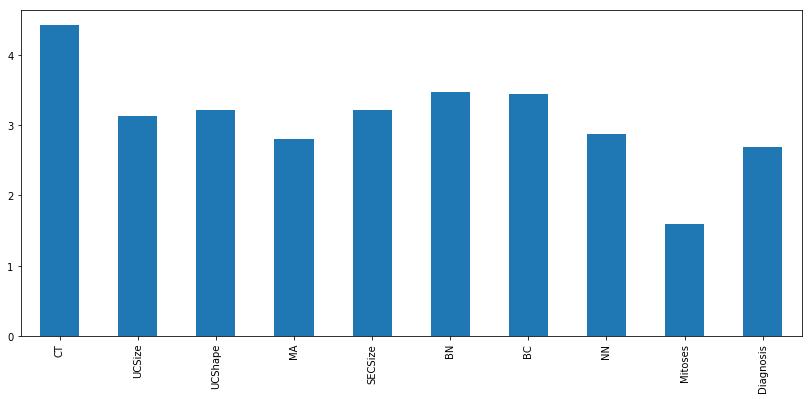

In [51]:
# Import Seaborn, a very powerful library for Data Visualisation
import seaborn as sns
data_mean = data.describe().loc['mean']
data_mean.plot(kind='bar', figsize=(14,6))

#### Samples from dataset labled as B

In [52]:
data_B = data[data['Diagnosis'] == 2]
data_B.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.0
mean,2.956332,1.325328,1.443231,1.364629,2.120087,1.305677,2.100437,1.290393,1.063319,2.0
std,1.674318,0.907694,0.997836,0.996830,0.917130,1.182666,1.080339,1.058856,0.501995,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.0
25%,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.0
50%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.0
75%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.0
max,8.000000,9.000000,8.000000,10.000000,10.000000,10.000000,7.000000,9.000000,8.000000,2.0


#### Samples from dataset labeled as M

In [53]:
data_M = data[data['Diagnosis'] == 4]
data_M.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.0
mean,7.195021,6.572614,6.560166,5.547718,5.298755,7.564315,5.979253,5.863071,2.589212,4.0
std,2.428849,2.719512,2.562045,3.210465,2.451606,3.180182,2.273852,3.350672,2.557939,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,4.0
25%,5.000000,4.000000,4.000000,3.000000,3.000000,5.000000,4.000000,3.000000,1.000000,4.0
50%,8.000000,6.000000,6.000000,5.000000,5.000000,10.000000,7.000000,6.000000,1.000000,4.0
75%,10.000000,10.000000,9.000000,8.000000,6.000000,10.000000,7.000000,10.000000,3.000000,4.0
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.0


#### Bar chart of the total numbers of B and M

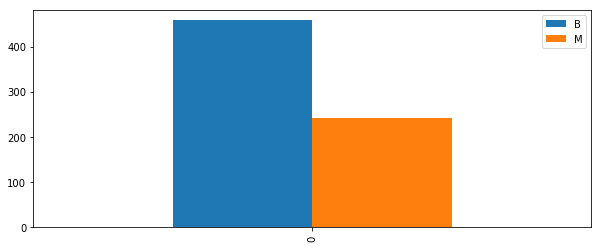

In [54]:
B_M_data = {'B': [data_B.shape[0]], 'M': [data_M.shape[0]]}
B_M_df = pd.DataFrame(data=B_M_data)
B_M_df.plot(kind='bar', figsize=(10,4))

#### Define a data generation function with random noise

In [55]:
def generateData(data1):
    # make a copy of data
    data2 = data1.copy()

    # separate labels from features
    diagnosis2 = data2['Diagnosis'] # labels
    features2 = data2.drop(['Diagnosis'], axis = 1)
    features2_headers = ["CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]

    mean, sigma = 0, 0.1 
    # creating a noise with the same dimension as the dataset 
    noise = np.random.normal(mean, sigma, features2.shape) 
    features2 = features2.apply(pd.to_numeric, errors='ignore')
    features2_with_noise = features2.add(pd.DataFrame(noise, columns = features2_headers), fill_value=0)
    data2 = pd.concat([features2_with_noise, pd.DataFrame(diagnosis2)], axis = 1)
    
    return data2

#### Expand the set of data samples labeled as M

In [56]:
data_M_copy = data_M.copy();

new_data_M = generateData(data_M_copy)
data_M = data_M.append(new_data_M, ignore_index=True)

data_M = data_M[data_M['Diagnosis'] >= 4.0]
data_M.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.0
mean,7.192115,6.572969,6.558791,5.546700,5.299794,7.564196,5.980679,5.861671,2.590798,4.0
std,2.423516,2.715746,2.559545,3.208487,2.446561,3.176905,2.270767,3.345342,2.557820,0.0
min,0.985313,1.000000,1.000000,0.848958,1.000000,-0.071472,1.000000,0.855214,0.844099,4.0
25%,5.000000,4.000000,4.012022,3.000000,3.000000,5.000000,4.000000,3.000000,1.000000,4.0
50%,8.000000,6.000000,6.203659,5.000000,5.000000,9.979027,6.964271,6.000000,1.004036,4.0
75%,9.969041,9.981751,9.000000,8.008201,6.113986,10.000000,7.096012,9.843978,3.000000,4.0
max,10.226449,10.196727,10.171941,10.207085,10.148341,10.300430,10.004126,10.185261,10.161728,4.0


#### Bar chart of the total numbers of B and M after expanding the set of samples labeled as M

,B,M
0,458,482


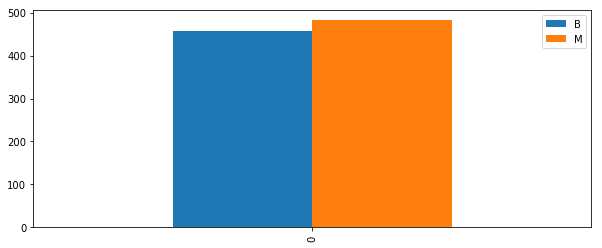

In [57]:
B_M_data = {'B': [data_B.shape[0]], 'M': [data_M.shape[0]]}
B_M_df = pd.DataFrame(data=B_M_data)
B_M_df.plot(kind='bar', figsize=(10,4))
B_M_df.head()

#### Combine the new set of M samples with the original set of B samples into one new dataset

In [58]:

data = data_B.append(data_M, ignore_index=True)
data.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000
mean,5.128297,4.016140,4.066316,3.509052,3.750532,4.514833,4.090093,3.634389,1.846558,3.025532
std,2.976628,3.326594,3.222637,3.182940,2.450343,3.955629,2.641022,3.391855,2.014331,1.000206
min,0.985313,1.000000,1.000000,0.848958,1.000000,-0.071472,1.000000,0.855214,0.844099,2.000000
25%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,5.000000,3.000000,3.000000,2.000000,3.000000,2.000000,3.000000,1.000000,1.000000,4.000000
75%,8.000000,6.935317,6.963016,5.061032,5.000000,10.000000,7.000000,6.000000,1.082532,4.000000
max,10.226449,10.196727,10.171941,10.207085,10.148341,10.300430,10.004126,10.185261,10.161728,4.000000


#### Expand the new combined dataset

In [59]:
data_copy = data;

new_data = generateData(data_copy)
data = data.append(new_data, ignore_index=True)

data = data.fillna(0)

print("data size = ", data.shape[0])

('data size = ', 1880)


#### Scale dataset to the range of [0, 1]

In [60]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ["Diagnosis","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]
data[numerical] = scaler.fit_transform(data[numerical])

#### Separate Labels/Classes from Features

In [61]:
diagnosis = data['Diagnosis']
features = data.drop(['Diagnosis'], axis = 1)

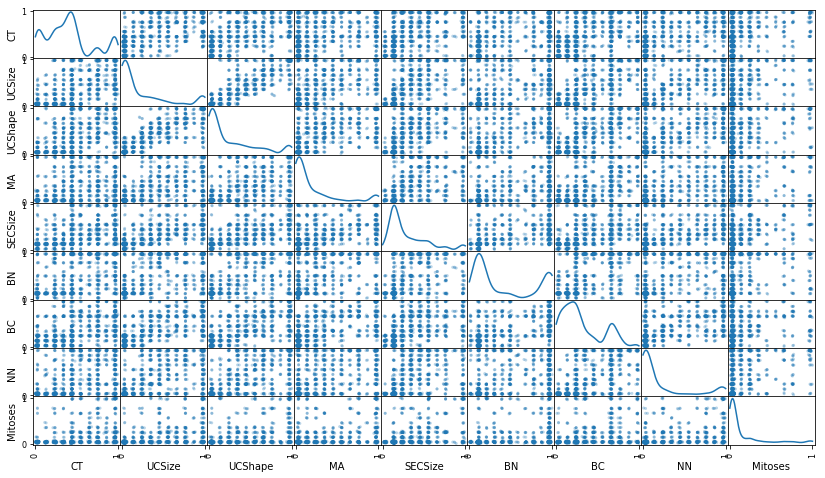

In [62]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(features, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

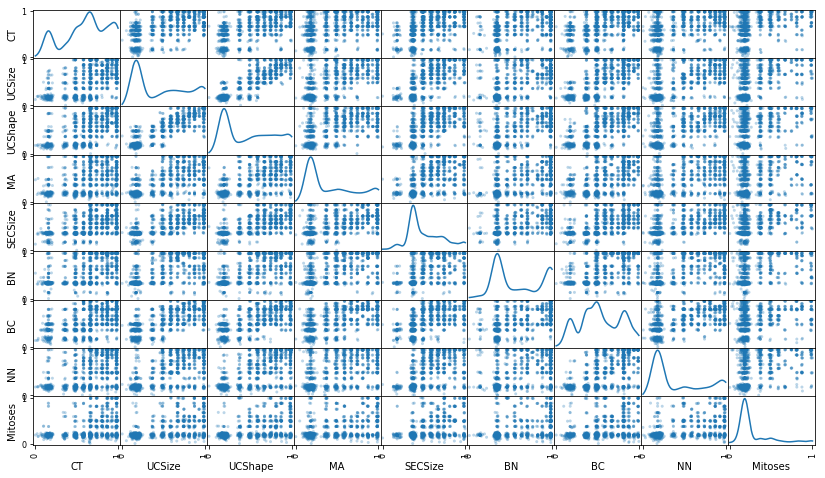

In [63]:
# Scale the data using squared root transformation
sqrt_features = features.copy()

for feature_name in sqrt_features.columns:
    sqrt_features[feature_name] = np.sqrt(sqrt_features[feature_name]) 
    
# sqrt_features = scaler.fit_transform(sqrt_features)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(pd.DataFrame(sqrt_features), alpha = 0.3, figsize = (14,8), diagonal = 'kde');

# convert numpy ndarray into Pandas DataFrame
features = pd.DataFrame(sqrt_features)

#### Split dataset into training and testing datasets

In [64]:
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, diagnosis, test_size=0.25, random_state=42)

#### Reindex 

In [65]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Convert Pandas DataFrame to Numpy ndarray
* This conversion is necessary because Pandas DataFrame is not consist with Keras API.

In [66]:
X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

#### Classify dataset using Random Forest Classifier

In [67]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

score = rfc.score(X_test, y_test)
print("score = ", score)

('score = ', 0.97446808510638294)


#### Deep learning

In [68]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
import keras
import keras.utils
from keras import utils as np_utils

#### Define NN Architecture
* add Dropout(0.5) does not produce noticable performance in accuracy once the epochs >= 500.

In [69]:
model = Sequential()

#Define your architecture.
model.add(Dense(9, activation='relu', input_dim=9))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu', input_shape=(9,)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', input_shape=(5,)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 9)                 90        
_________________________________________________________________
dropout_3 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 50        
_________________________________________________________________
dropout_4 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


#### Compile NN Model
* Note that the "accuracy" metrics supports the history of "acc", but the "binary_accuracy" accuracy does not!

In [70]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy']) # ['binary_accuracy']

In [71]:
from sklearn.metrics import roc_auc_score

class LossAccHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuries = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        y_pred = self.model.predict(self.model.validation_data[0])
        self.accuries.append(roc_auc_score(self.model.validation_data[1], y_pred))
        # self.accuracies.append(logs.get('acc'))

#### Train NN Model

In [72]:
# model.fit(X_train, y_train, epochs=800, batch_size=16) # (500, 16) = 0.974286, 32 - 0.968571
# history = LossAccHistory()
history = model.fit(X_train, y_train, epochs=1000, batch_size=16, verbose=1)

Epoch 1/1000
1410/1410 [==============================] - 0s - loss: 0.7121 - acc: 0.4766     
Epoch 2/1000
1410/1410 [==============================] - 0s - loss: 0.6899 - acc: 0.4965     
Epoch 3/1000
1410/1410 [==============================] - 0s - loss: 0.6733 - acc: 0.5071     
Epoch 4/1000
1410/1410 [==============================] - 0s - loss: 0.6463 - acc: 0.5369     
Epoch 5/1000
1410/1410 [==============================] - 0s - loss: 0.6234 - acc: 0.5816     
Epoch 6/1000
1410/1410 [==============================] - 0s - loss: 0.5868 - acc: 0.6582     
Epoch 7/1000
1410/1410 [==============================] - 0s - loss: 0.5770 - acc: 0.6816     
Epoch 8/1000
1410/1410 [==============================] - 0s - loss: 0.5539 - acc: 0.7291     
Epoch 9/1000
1410/1410 [==============================] - 0s - loss: 0.5319 - acc: 0.7624     
Epoch 10/1000
1410/1410 [==============================] - 0s - loss: 0.5188 - acc: 0.7780     
Epoch 11/1000
1410/1410 [========================

1410/1410 [==============================] - 0s - loss: 0.2594 - acc: 0.9142     
Epoch 87/1000
1410/1410 [==============================] - 0s - loss: 0.2451 - acc: 0.9085     
Epoch 88/1000
1410/1410 [==============================] - 0s - loss: 0.2623 - acc: 0.9085     
Epoch 89/1000
1410/1410 [==============================] - 0s - loss: 0.2643 - acc: 0.9000     
Epoch 90/1000
1410/1410 [==============================] - 0s - loss: 0.2689 - acc: 0.9000     
Epoch 91/1000
1410/1410 [==============================] - 0s - loss: 0.2800 - acc: 0.9014     
Epoch 92/1000
1410/1410 [==============================] - 0s - loss: 0.2636 - acc: 0.9035     
Epoch 93/1000
1410/1410 [==============================] - 0s - loss: 0.2707 - acc: 0.9064     
Epoch 94/1000
1410/1410 [==============================] - 0s - loss: 0.2548 - acc: 0.9071     
Epoch 95/1000
1410/1410 [==============================] - 0s - loss: 0.2687 - acc: 0.9014     
Epoch 96/1000
1410/1410 [=============================

1410/1410 [==============================] - 0s - loss: 0.2475 - acc: 0.9135     
Epoch 171/1000
1410/1410 [==============================] - 0s - loss: 0.2561 - acc: 0.9028     
Epoch 172/1000
1410/1410 [==============================] - 0s - loss: 0.2552 - acc: 0.9071     
Epoch 173/1000
1410/1410 [==============================] - 0s - loss: 0.2451 - acc: 0.9128     
Epoch 174/1000
1410/1410 [==============================] - 0s - loss: 0.2486 - acc: 0.9092     
Epoch 175/1000
1410/1410 [==============================] - 0s - loss: 0.2331 - acc: 0.9163     
Epoch 176/1000
1410/1410 [==============================] - 0s - loss: 0.2799 - acc: 0.8936     
Epoch 177/1000
1410/1410 [==============================] - 0s - loss: 0.2520 - acc: 0.9085     
Epoch 178/1000
1410/1410 [==============================] - 0s - loss: 0.2482 - acc: 0.9071     
Epoch 179/1000
1410/1410 [==============================] - 0s - loss: 0.2573 - acc: 0.9071     
Epoch 180/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.2391 - acc: 0.9149     
Epoch 255/1000
1410/1410 [==============================] - 0s - loss: 0.2369 - acc: 0.9057     
Epoch 256/1000
1410/1410 [==============================] - 0s - loss: 0.2563 - acc: 0.9128     
Epoch 257/1000
1410/1410 [==============================] - 0s - loss: 0.2473 - acc: 0.9149     
Epoch 258/1000
1410/1410 [==============================] - 0s - loss: 0.2362 - acc: 0.9071     
Epoch 259/1000
1410/1410 [==============================] - 0s - loss: 0.2366 - acc: 0.9142     
Epoch 260/1000
1410/1410 [==============================] - 0s - loss: 0.2427 - acc: 0.9043     
Epoch 261/1000
1410/1410 [==============================] - 0s - loss: 0.2450 - acc: 0.9106     
Epoch 262/1000
1410/1410 [==============================] - 0s - loss: 0.2599 - acc: 0.9085     
Epoch 263/1000
1410/1410 [==============================] - 0s - loss: 0.2529 - acc: 0.9220     
Epoch 264/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.2546 - acc: 0.9092     
Epoch 339/1000
1410/1410 [==============================] - 0s - loss: 0.2375 - acc: 0.9184     
Epoch 340/1000
1410/1410 [==============================] - 0s - loss: 0.2548 - acc: 0.9043     
Epoch 341/1000
1410/1410 [==============================] - 0s - loss: 0.2561 - acc: 0.9014     
Epoch 342/1000
1410/1410 [==============================] - 0s - loss: 0.2324 - acc: 0.9113     
Epoch 343/1000
1410/1410 [==============================] - 0s - loss: 0.2647 - acc: 0.8957     
Epoch 344/1000
1410/1410 [==============================] - 0s - loss: 0.2629 - acc: 0.9000     
Epoch 345/1000
1410/1410 [==============================] - 0s - loss: 0.2405 - acc: 0.9170     
Epoch 346/1000
1410/1410 [==============================] - 0s - loss: 0.2543 - acc: 0.9050     
Epoch 347/1000
1410/1410 [==============================] - 0s - loss: 0.2624 - acc: 0.9043     
Epoch 348/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.2494 - acc: 0.9163     
Epoch 423/1000
1410/1410 [==============================] - 0s - loss: 0.2568 - acc: 0.9064     
Epoch 424/1000
1410/1410 [==============================] - 0s - loss: 0.2417 - acc: 0.9170     
Epoch 425/1000
1410/1410 [==============================] - 0s - loss: 0.2447 - acc: 0.9064     
Epoch 426/1000
1410/1410 [==============================] - 0s - loss: 0.2675 - acc: 0.8908     
Epoch 427/1000
1410/1410 [==============================] - 0s - loss: 0.2542 - acc: 0.9014     
Epoch 428/1000
1410/1410 [==============================] - 0s - loss: 0.2425 - acc: 0.9113     
Epoch 429/1000
1410/1410 [==============================] - 0s - loss: 0.2490 - acc: 0.9142     
Epoch 430/1000
1410/1410 [==============================] - 0s - loss: 0.2510 - acc: 0.9113     
Epoch 431/1000
1410/1410 [==============================] - 0s - loss: 0.2373 - acc: 0.9149     
Epoch 432/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.2361 - acc: 0.9142     
Epoch 507/1000
1410/1410 [==============================] - 0s - loss: 0.2448 - acc: 0.9085     
Epoch 508/1000
1410/1410 [==============================] - 0s - loss: 0.2461 - acc: 0.9113     
Epoch 509/1000
1410/1410 [==============================] - 0s - loss: 0.2411 - acc: 0.9021     
Epoch 510/1000
1410/1410 [==============================] - 0s - loss: 0.2328 - acc: 0.9149     
Epoch 511/1000
1410/1410 [==============================] - 0s - loss: 0.2129 - acc: 0.9220     
Epoch 512/1000
1410/1410 [==============================] - 0s - loss: 0.2330 - acc: 0.9078     
Epoch 513/1000
1410/1410 [==============================] - 0s - loss: 0.2536 - acc: 0.9170     
Epoch 514/1000
1410/1410 [==============================] - 0s - loss: 0.2569 - acc: 0.8957     
Epoch 515/1000
1410/1410 [==============================] - 0s - loss: 0.2322 - acc: 0.9213     
Epoch 516/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.2398 - acc: 0.9135     
Epoch 591/1000
1410/1410 [==============================] - 0s - loss: 0.2343 - acc: 0.9142     
Epoch 592/1000
1410/1410 [==============================] - 0s - loss: 0.2327 - acc: 0.9184     
Epoch 593/1000
1410/1410 [==============================] - 0s - loss: 0.2369 - acc: 0.9106     
Epoch 594/1000
1410/1410 [==============================] - 0s - loss: 0.2351 - acc: 0.9142     
Epoch 595/1000
1410/1410 [==============================] - 0s - loss: 0.2712 - acc: 0.8972     
Epoch 596/1000
1410/1410 [==============================] - 0s - loss: 0.2346 - acc: 0.9092     
Epoch 597/1000
1410/1410 [==============================] - 0s - loss: 0.2820 - acc: 0.9007     
Epoch 598/1000
1410/1410 [==============================] - 0s - loss: 0.2409 - acc: 0.9163     
Epoch 599/1000
1410/1410 [==============================] - 0s - loss: 0.2525 - acc: 0.9043     
Epoch 600/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.2431 - acc: 0.9135     
Epoch 674/1000
1410/1410 [==============================] - 0s - loss: 0.2555 - acc: 0.9142     
Epoch 675/1000
1410/1410 [==============================] - 0s - loss: 0.2476 - acc: 0.9156     
Epoch 676/1000
1410/1410 [==============================] - 0s - loss: 0.2294 - acc: 0.9085     
Epoch 677/1000
1410/1410 [==============================] - 0s - loss: 0.2227 - acc: 0.9277     
Epoch 678/1000
1410/1410 [==============================] - 0s - loss: 0.2577 - acc: 0.9142     
Epoch 679/1000
1410/1410 [==============================] - 0s - loss: 0.2539 - acc: 0.9156     
Epoch 680/1000
1410/1410 [==============================] - 0s - loss: 0.2448 - acc: 0.9043     
Epoch 681/1000
1410/1410 [==============================] - 0s - loss: 0.2453 - acc: 0.9050     
Epoch 682/1000
1410/1410 [==============================] - 0s - loss: 0.2618 - acc: 0.9064     
Epoch 683/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.2544 - acc: 0.9043     
Epoch 758/1000
1410/1410 [==============================] - 0s - loss: 0.2214 - acc: 0.9220     
Epoch 759/1000
1410/1410 [==============================] - 0s - loss: 0.2535 - acc: 0.9007     
Epoch 760/1000
1410/1410 [==============================] - 0s - loss: 0.2435 - acc: 0.9021     
Epoch 761/1000
1410/1410 [==============================] - 0s - loss: 0.2493 - acc: 0.9135     
Epoch 762/1000
1410/1410 [==============================] - 0s - loss: 0.2434 - acc: 0.9064     
Epoch 763/1000
1410/1410 [==============================] - 0s - loss: 0.2452 - acc: 0.9028     
Epoch 764/1000
1410/1410 [==============================] - 0s - loss: 0.2650 - acc: 0.9057     
Epoch 765/1000
1410/1410 [==============================] - 0s - loss: 0.2404 - acc: 0.9113     
Epoch 766/1000
1410/1410 [==============================] - 0s - loss: 0.2508 - acc: 0.9142     
Epoch 767/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.2367 - acc: 0.9163     
Epoch 842/1000
1410/1410 [==============================] - 0s - loss: 0.2218 - acc: 0.9156     
Epoch 843/1000
1410/1410 [==============================] - 0s - loss: 0.2478 - acc: 0.9092     
Epoch 844/1000
1410/1410 [==============================] - 0s - loss: 0.2344 - acc: 0.9149     
Epoch 845/1000
1410/1410 [==============================] - 0s - loss: 0.2403 - acc: 0.9213     
Epoch 846/1000
1410/1410 [==============================] - 0s - loss: 0.2676 - acc: 0.9085     
Epoch 847/1000
1410/1410 [==============================] - 0s - loss: 0.2557 - acc: 0.9085     
Epoch 848/1000
1410/1410 [==============================] - 0s - loss: 0.2582 - acc: 0.9071     
Epoch 849/1000
1410/1410 [==============================] - 0s - loss: 0.2397 - acc: 0.9092     
Epoch 850/1000
1410/1410 [==============================] - 0s - loss: 0.2274 - acc: 0.9163     
Epoch 851/1000
1410/1410 [===================

1410/1410 [==============================] - 0s - loss: 0.2443 - acc: 0.9085     
Epoch 926/1000
1410/1410 [==============================] - 0s - loss: 0.2561 - acc: 0.9099     
Epoch 927/1000
1410/1410 [==============================] - 0s - loss: 0.2599 - acc: 0.9092     
Epoch 928/1000
1410/1410 [==============================] - 0s - loss: 0.2561 - acc: 0.9184     
Epoch 929/1000
1410/1410 [==============================] - 0s - loss: 0.2366 - acc: 0.9057     
Epoch 930/1000
1410/1410 [==============================] - 0s - loss: 0.2173 - acc: 0.9170     
Epoch 931/1000
1410/1410 [==============================] - 0s - loss: 0.2592 - acc: 0.9085     
Epoch 932/1000
1410/1410 [==============================] - 0s - loss: 0.2486 - acc: 0.9106     
Epoch 933/1000
1410/1410 [==============================] - 0s - loss: 0.2730 - acc: 0.8965     
Epoch 934/1000
1410/1410 [==============================] - 0s - loss: 0.2330 - acc: 0.9220     
Epoch 935/1000
1410/1410 [===================

<type 'list'>


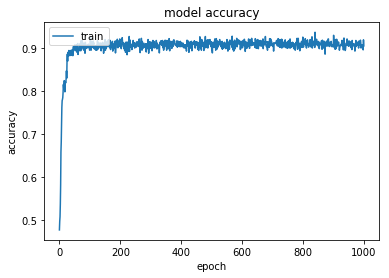

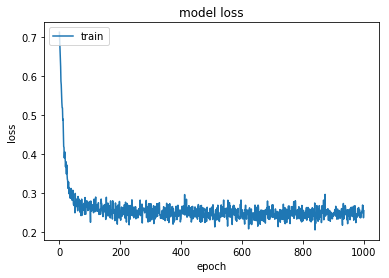

In [73]:
print(type(history.history['acc']))

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Test NN Model

In [74]:
score = model.evaluate(X_test, y_test, batch_size=16) # 16 - 0.974286, 32 - 0.968571
print("score = ", score)

 16/470 [>.............................] - ETA: 1s('score = ', [0.12814344489511023, 0.97446808510638294])


#### Draw ROC Curve

 32/470 [=>............................] - ETA: 0s

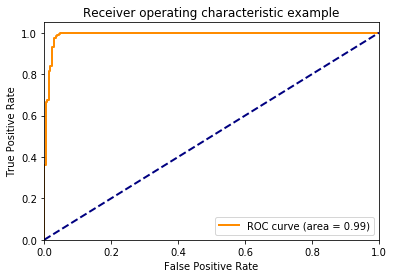

In [75]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

y_pred = model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()